In [257]:
import pandas as pd 
import mysql.connector

In [258]:
df = pd.read_csv('Produits - Feuille 1.csv')
df = df.drop_duplicates()
df['Code article'] = df['Code article'].drop_duplicates()
df = df.dropna()

In [278]:
cnx = mysql.connector.connect(user='root', password='root',
                              host='127.0.0.1',
                              database='exos_produits')

In [260]:
cursor = cnx.cursor(buffered=True)
sql = """ CREATE TABLE `dim_famille` (
`id_famille` mediumint(8) UNSIGNED NOT NULL auto_increment,
`famille` varchar(100) default NULL,
PRIMARY KEY (`id_famille`),
UNIQUE KEY `famille` (`famille`)
);"""
cursor.execute(sql)


In [261]:

table2 = """ CREATE TABLE `dim_condition` (
`id_condition` mediumint(8) UNSIGNED NOT NULL auto_increment,
`condition` varchar(100) default NULL,
PRIMARY KEY (`id_condition`),
UNIQUE KEY `condition` (`condition`)
);"""
cursor.execute(table2)
cnx.commit()

In [262]:
#df des familles unique 
df_famille = tuple(pd.unique(df['FAMILLE ARTICLE']))

In [263]:
cursor = cnx.cursor(buffered=True)
for y in df_famille:
    edit_famille = """ INSERT INTO `dim_famille` (`famille`)    
                        VALUES (%s); """

    cursor.execute(edit_famille, (y,))

In [264]:
#idem pour condition
df_condition = tuple(pd.unique(df['CONDITION']))


In [265]:
for y in df_condition:
    edit_condition = """ INSERT INTO `dim_condition` (`condition`)    
                        VALUES (%s); """

    cursor.execute(edit_condition, (y,))

In [266]:
table_produit = """CREATE TABLE `produits` (
                    `id_produits` mediumint(8),
                    `name` varchar(100),
                    `prix` FLOAT,
                    `famille_key` mediumint(8) UNSIGNED NOT NULL,
                    `condition_key` mediumint(8) UNSIGNED NOT NULL,
                    PRIMARY KEY (`id_produits`),
                    FOREIGN KEY (`famille_key`) REFERENCES `dim_famille`(`id_famille`),
                    FOREIGN KEY (`condition_key`) REFERENCES `dim_condition`(`id_condition`)
                    );"""
cursor.execute(table_produit)

In [267]:
#Read table famille
cursor = cnx.cursor(buffered=True)

read_famille = """SELECT `id_famille`, `famille` FROM dim_famille"""
cursor.execute(read_famille)
famille_table = cursor.fetchall()
# for id_famille, famille in cursor:
#     print(f'{id_famille} , {famille}')

In [268]:
famille_table = dict(famille_table)

In [269]:
for key, value in famille_table.items():
    df['FAMILLE ARTICLE'] = df['FAMILLE ARTICLE'].replace(to_replace= value, value= key)

In [270]:
#on fait la même pour les conditionnements 
read_cond = """SELECT `id_condition`, `condition` FROM dim_condition"""
cursor.execute(read_cond)
cond_table = cursor.fetchall()

In [271]:
cond_table = dict(cond_table)
for key, value in cond_table.items():
    df['CONDITION'] = df['CONDITION'].replace(to_replace= value, value= key)

In [272]:
def SQL_INSERT(dataframe, TARGET, colonnes_db):
    sql_texts = []
    for index, row in dataframe.iterrows():       
        sql_texts.append('INSERT INTO '+TARGET+' ('+ str(', '.join(colonnes_db))+ ') VALUES '+ str(tuple(row.values)))        
    return sql_texts

col_db =['id_produits', 'name', 'prix', 'famille_key', 'condition_key']

#on a été con donc il faut réorganiser le dataframe pour l'ordre des colonnes
df = df.reindex(columns=['Code article', 'LIBELLE ARTICLE', 'PU HT','FAMILLE ARTICLE', 'CONDITION'])

In [273]:
#la colonne des prix est un string avec une , il faut convertir 

df['PU HT']= df['PU HT'].apply(lambda x: x.replace(',','.')).astype(float)


#et il y a encore des dupli dans les codes
# for y in df['Code article'].duplicated():
#     if y == True:
#         print(y)

# df['Code article'] = df['Code article'].drop_duplicates()


In [274]:
query_produits = SQL_INSERT(df, 'produits', col_db)

["INSERT INTO produits (id_produits, name, prix, famille_key, condition_key) VALUES (1010.0, 'HUILE ARACHIDE 25 L', 60.71, 1, 1)",
 "INSERT INTO produits (id_produits, name, prix, famille_key, condition_key) VALUES (1011.0, 'HUILE ARACHIDE 5 L', 14.33, 1, 1)",
 "INSERT INTO produits (id_produits, name, prix, famille_key, condition_key) VALUES (1012.0, 'HUILE ARACHIDE 1 L', 2.87, 1, 2)",
 "INSERT INTO produits (id_produits, name, prix, famille_key, condition_key) VALUES (1014.0, 'HUILE MEZZO 1 L (50%OLIVE50%TOURNESOL)', 2.67, 1, 2)",
 "INSERT INTO produits (id_produits, name, prix, famille_key, condition_key) VALUES (1015.0, 'HUILE COLZA 5 L', 7.57, 1, 1)",
 "INSERT INTO produits (id_produits, name, prix, famille_key, condition_key) VALUES (1016.0, 'HUILE COLZA 1 L', 1.71, 1, 2)",
 "INSERT INTO produits (id_produits, name, prix, famille_key, condition_key) VALUES (1020.0, 'HUILE TOURNESOL 25 L', 37.14, 1, 1)",
 "INSERT INTO produits (id_produits, name, prix, famille_key, condition_key) 

In [275]:
for y in query_produits:
    cursor.execute(y)

In [276]:
cnx.commit()

In [277]:
cnx.close()

In [281]:
#maintenant essayer de faire une requete afin de tracers l'histogramme des familles / emballages
cursor = cnx.cursor(buffered=True)
query_famille = """SELECT produits.name, dim_famille.famille FROM produits
                    JOIN dim_famille on dim_famille.id_famille = produits.famille_key """
cursor.execute(query_famille)
query_f = pd.DataFrame(cursor.fetchall(), columns=['Article', 'Famille'])
query_f


,Article,Famille
0,FONDS DE TARTE SABLES 28 CM X 12,ALCOOLS CHAMPAGNE MOUSSEUX VINS
1,MOUSSEUX A.ROMET 75CL,ALCOOLS CHAMPAGNE MOUSSEUX VINS
2,BELLINI 75 CL,ALCOOLS CHAMPAGNE MOUSSEUX VINS
3,SPECIALITÉ BASE BEURRE A LA TRUFFE 165G,BEURRE ET MARGARINE
4,BEURRE A LA TRUFFE 500G,BEURRE ET MARGARINE
...,...,...
1856,POIRE BOEUF PAD SV,VIANDE
1857,ENTRECOTE SIMMENTAL KG,VIANDE
1858,ROTI ECHINE PORC S/OS,VIANDE
1859,ONGLET BOEUF PAD SV,VIANDE


C:\Users\simplet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\simplet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='Famille'>

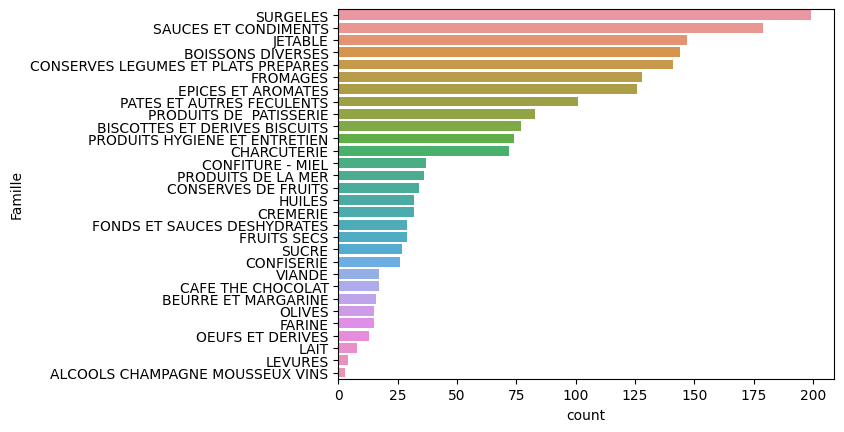

In [314]:
import seaborn as sns

sns.countplot(data=query_f,y=query_f['Famille'], order=query_f['Famille'].value_counts().index )

C:\Users\simplet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\simplet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='Condition'>

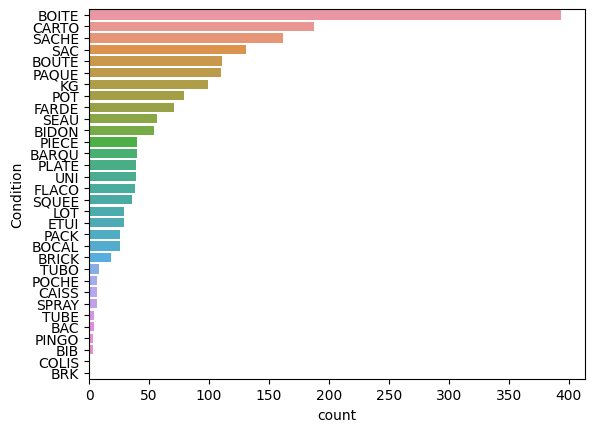

In [312]:
#la même pour les emballages
query_con = """SELECT produits.condition_key, dim_condition.condition FROM produits
                    JOIN dim_condition ON dim_condition.id_condition = produits.condition_key
                     """
cursor.execute(query_con)
query_c = pd.DataFrame(cursor.fetchall(), columns=['Nom', 'Condition'])

sns.countplot(data=query_c,y=query_c['Condition'], order= query_c['Condition'].value_counts().index )